# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 200     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7398.2685546875
iteration 0 loss 3475.83740234375


iteration 5000 loss 0.7614874839782715


iteration 10000 loss 0.19503837823867798


iteration 15000 loss 0.11235859245061874


iteration 20000 loss 0.0793071985244751


iteration 25000 loss 0.06861583143472672


iteration 30000 loss 0.04757422208786011


iteration 35000 loss 0.03587822616100311


iteration 40000 loss 0.02987951599061489


iteration 45000 loss 0.028636641800403595


iteration 50000 loss 0.031919531524181366


iteration 55000 loss 0.015493624843657017


iteration 60000 loss 0.013217278756201267


iteration 65000 loss 0.011431259103119373


iteration 70000 loss 0.07782032340765


iteration 75000 loss 1.0934033393859863


iteration 80000 loss 0.007422939874231815


iteration 85000 loss 0.07551259547472


iteration 90000 loss 0.007403835654258728


iteration 95000 loss 0.005318806506693363


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.004472095984965563


iteration 105000 loss 0.00358818587847054


iteration 110000 loss 0.12197953462600708


iteration 115000 loss 0.006265024654567242


iteration 120000 loss 0.002154521644115448


iteration 125000 loss 0.0018759234808385372


iteration 130000 loss 0.0016395917627960443


iteration 135000 loss 0.0015137724112719297


iteration 140000 loss 0.0012737612705677748


iteration 145000 loss 0.0011280369944870472


iteration 150000 loss 0.0010025444207713008


iteration 155000 loss 0.0008932497585192323


iteration 160000 loss 0.0007947129779495299


iteration 165000 loss 0.0007099435315467417


iteration 170000 loss 0.0006347815506160259


iteration 175000 loss 0.0005671397666446865


iteration 180000 loss 0.0005095606902614236


iteration 185000 loss 0.00047177018132060766


iteration 190000 loss 0.0004108721623197198


iteration 195000 loss 0.00036984027246944606


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0003335328074172139


iteration 205000 loss 0.00031754554947838187


iteration 210000 loss 0.00029042153619229794


iteration 215000 loss 0.00026530437753535807


iteration 220000 loss 0.00024301039229612797


iteration 225000 loss 0.00022287186584435403


iteration 230000 loss 0.00020495419448707253


iteration 235000 loss 0.00019523079390637577


iteration 240000 loss 0.0001719695865176618


iteration 245000 loss 0.00015818056999705732


iteration 250000 loss 0.00014585409371647984


iteration 255000 loss 0.00013383565237745643


iteration 260000 loss 0.00012341472029220313


iteration 265000 loss 0.00011394028115319088


iteration 270000 loss 0.00010513071902096272


iteration 275000 loss 9.686757402960211e-05


iteration 280000 loss 8.951128256740049e-05


iteration 285000 loss 8.256480214186013e-05


iteration 290000 loss 7.716241816524416e-05


iteration 295000 loss 7.100608490873128e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 6.507934449473396e-05


iteration 305000 loss 6.28734051133506e-05


iteration 310000 loss 5.8166897360933945e-05


iteration 315000 loss 5.377681736717932e-05


iteration 320000 loss 4.978880315320566e-05


iteration 325000 loss 4.6226883569033816e-05


iteration 330000 loss 4.284042734070681e-05


iteration 335000 loss 3.976375228376128e-05


iteration 340000 loss 3.692312748171389e-05


iteration 345000 loss 3.426395414862782e-05


iteration 350000 loss 3.1867068173596635e-05


iteration 355000 loss 2.965630301332567e-05


iteration 360000 loss 2.7529340513865463e-05


iteration 365000 loss 2.5695238946354948e-05


iteration 370000 loss 2.389327528362628e-05


iteration 375000 loss 2.2217347577679902e-05


iteration 380000 loss 2.0777479221578687e-05


iteration 385000 loss 1.932405575644225e-05


iteration 390000 loss 1.8069835277856328e-05


iteration 395000 loss 1.6821220924612135e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 1.5737938156235032e-05


iteration 405000 loss 1.5246146176650655e-05


iteration 410000 loss 1.3838481208949815e-05


iteration 415000 loss 1.2583021089085378e-05


iteration 420000 loss 1.1451545105956029e-05


iteration 425000 loss 1.0439144716656301e-05


iteration 430000 loss 9.520925232209265e-06


iteration 435000 loss 8.690057256899308e-06


iteration 440000 loss 7.943379387143068e-06


iteration 445000 loss 7.27696533431299e-06


iteration 450000 loss 6.676452358078677e-06


iteration 455000 loss 6.150949047878385e-06


iteration 460000 loss 5.660319857270224e-06


iteration 465000 loss 5.217335910856491e-06


iteration 470000 loss 4.821128641196992e-06


iteration 475000 loss 4.450048436410725e-06


iteration 480000 loss 4.1167163544741925e-06


iteration 485000 loss 3.959004516218556e-06


iteration 490000 loss 3.5136081351083703e-06


iteration 495000 loss 3.2470468340761727e-06


L2 loss -- Plot

loss -62.42369079589844


loss -231.95492553710938


loss -326.6905517578125


loss -409.10736083984375


loss -483.6181640625


loss -549.631103515625


loss -606.370849609375


loss -653.6399536132812


loss -692.164794921875


loss -722.9780883789062


loss -746.94921875


loss -764.9298095703125


loss -777.8547973632812


loss -786.7177734375


loss -792.5009765625


loss -796.076416015625


loss -798.1481323242188


loss -799.2520751953125


loss -799.7796630859375


loss -799.9983520507812


loss -800.0733642578125


loss -800.0933227539062


loss -800.0971069335938


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


loss -800.0975341796875


final mse:  8.862637845830079e-10
max, min: 6.427222 -7.6686215
loss -62.42369079589844


loss -232.86618041992188


loss -330.9107971191406


loss -418.6439208984375


loss -500.41058349609375


loss -575.5615234375


loss -643.0706176757812


loss -702.0487060546875


loss -752.2371215820312


loss -793.9780883789062


loss -827.7962036132812


loss -854.3718872070312


loss -874.52880859375


loss -889.1878662109375


loss -899.3228759765625


loss -905.923828125


loss -909.9366455078125


loss -912.187744140625


loss -913.3323974609375


loss -913.84521484375


loss -914.0397338867188


loss -914.0989379882812


loss -914.1124267578125


loss -914.1145629882812


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


loss -914.11474609375


final mse:  1.0390412974459196e-09
max, min: 7.706679 -7.894334


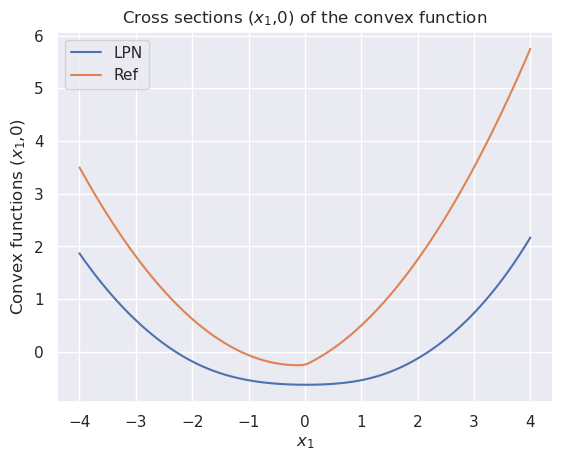

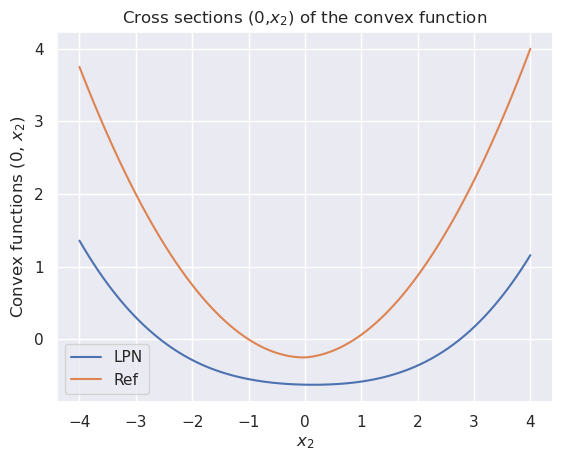

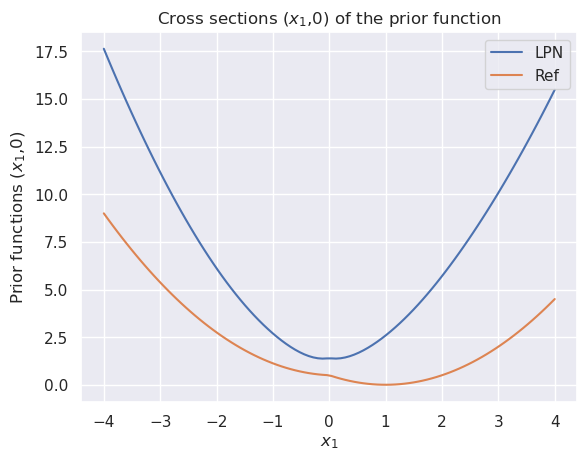

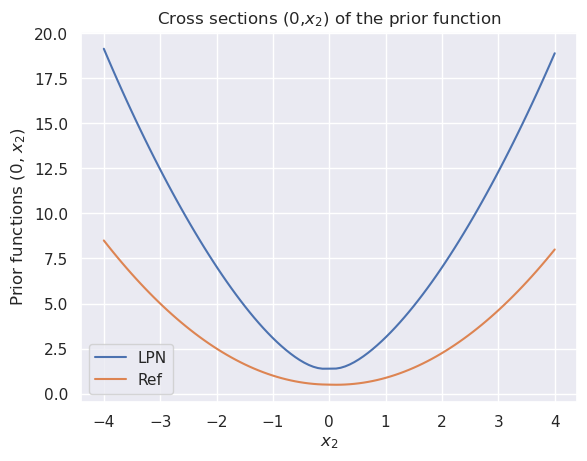

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 4985.60009765625
iteration 0 loss 3167.164306640625


iteration 5000 loss 1.2481592893600464


iteration 10000 loss 0.2575525939464569


iteration 15000 loss 0.13007692992687225


iteration 20000 loss 0.08561310917139053


iteration 25000 loss 0.0665658637881279


iteration 30000 loss 0.059982046484947205


iteration 35000 loss 0.04884246736764908


iteration 40000 loss 0.03908678516745567


iteration 45000 loss 0.03547351434826851


iteration 50000 loss 0.03232762962579727


iteration 55000 loss 0.027738992124795914


iteration 60000 loss 0.02788018435239792


iteration 65000 loss 0.022389616817235947


iteration 70000 loss 0.02159939333796501


iteration 75000 loss 0.017606819048523903


iteration 80000 loss 0.01638955995440483


iteration 85000 loss 0.015409326180815697


iteration 90000 loss 0.014348506927490234


iteration 95000 loss 0.015912966802716255


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.011202276684343815


iteration 105000 loss 0.009706534445285797


iteration 110000 loss 0.008266119286417961


iteration 115000 loss 0.007126875687390566


iteration 120000 loss 0.006236323621124029


iteration 125000 loss 0.005519018974155188


iteration 130000 loss 0.004889929201453924


iteration 135000 loss 0.0043853470124304295


iteration 140000 loss 0.00393279641866684


iteration 145000 loss 0.0035322546027600765


iteration 150000 loss 0.0032087676227092743


iteration 155000 loss 0.002917693695053458


iteration 160000 loss 0.0026696340646594763


iteration 165000 loss 0.002445436315611005


iteration 170000 loss 0.002252254169434309


iteration 175000 loss 0.002080814214423299


iteration 180000 loss 0.0019271783530712128


iteration 185000 loss 0.0017863967223092914


iteration 190000 loss 0.001661187270656228


iteration 195000 loss 0.0015464259777218103


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0014483866980299354


iteration 205000 loss 0.0014134155353531241


iteration 210000 loss 0.0013222205452620983


iteration 215000 loss 0.0012369508622214198


iteration 220000 loss 0.001158817089162767


iteration 225000 loss 0.0010885163210332394


iteration 230000 loss 0.0010214521316811442


iteration 235000 loss 0.0009592916467227042


iteration 240000 loss 0.0009049712098203599


iteration 245000 loss 0.0008522655116394162


iteration 250000 loss 0.0008068021852523088


iteration 255000 loss 0.00076362892286852


iteration 260000 loss 0.0007225360022857785


iteration 265000 loss 0.0006837241817265749


iteration 270000 loss 0.0006501076859422028


iteration 275000 loss 0.0006173513829708099


iteration 280000 loss 0.0010066397953778505


iteration 285000 loss 0.0005570862558670342


iteration 290000 loss 0.0005305623635649681


iteration 295000 loss 0.0005047143204137683


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0004805352946277708


iteration 305000 loss 0.000474378204671666


iteration 310000 loss 0.0004498479247558862


iteration 315000 loss 0.00042569427751004696


iteration 320000 loss 0.0004038006591144949


iteration 325000 loss 0.0003832214861176908


iteration 330000 loss 0.000363753701094538


iteration 335000 loss 0.000345907494192943


iteration 340000 loss 0.00032913521863520145


iteration 345000 loss 0.0003131934499833733


iteration 350000 loss 0.0002988938649650663


iteration 355000 loss 0.00028532600845210254


iteration 360000 loss 0.00027215047157369554


iteration 365000 loss 0.00025968890986405313


iteration 370000 loss 0.00024776533246040344


iteration 375000 loss 0.00023660594888497144


iteration 380000 loss 0.00022667934536002576


iteration 385000 loss 0.00021705435938201845


iteration 390000 loss 0.00020805449457839131


iteration 395000 loss 0.00019942755170632154


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00019165674166288227


iteration 405000 loss 0.0001888558326754719


iteration 410000 loss 0.00018044575699605048


iteration 415000 loss 0.0001718665153020993


iteration 420000 loss 0.00016382984176743776


iteration 425000 loss 0.00015627533139195293


iteration 430000 loss 0.00014909043966326863


iteration 435000 loss 0.0001421922934241593


iteration 440000 loss 0.00013564674009103328


iteration 445000 loss 0.0001294258254347369


iteration 450000 loss 0.00012351367331575602


iteration 455000 loss 0.00011784374510170892


iteration 460000 loss 0.00011243596964050084


iteration 465000 loss 0.00010728296911111102


iteration 470000 loss 0.00010236756497761235


iteration 475000 loss 9.768275776877999e-05


iteration 480000 loss 9.321101970272139e-05


iteration 485000 loss 8.895573409972712e-05


iteration 490000 loss 8.489122410537675e-05


iteration 495000 loss 8.101972343865782e-05


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


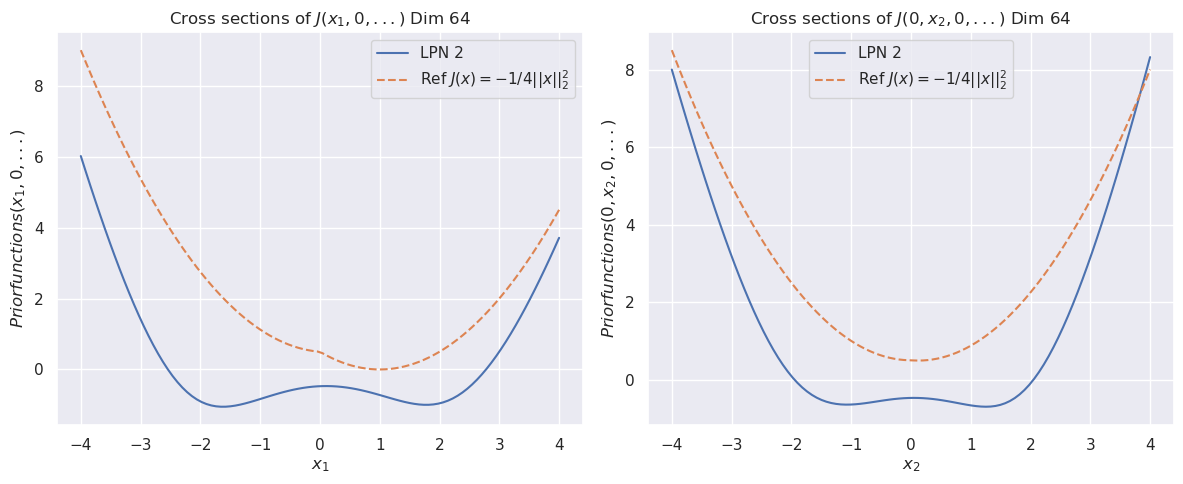

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)